# GHP Construction with Duration Matching

In [4]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import edhec_risk_kit as erk

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We are going to do a work around the problem of not having a zero coupon bond available.

In [6]:
erk.bond_cash_flows(3, 100, 0.03, 2)

1      1.5
2      1.5
3      1.5
4      1.5
5      1.5
6    101.5
dtype: float64

In [7]:
erk.bond_price(20, 1000, 0.05, 2, 0.04)

1136.7773962036904

This coupon is selling at a premium because it's paying a coupon of 5% that is higher than the current interest rate (4%)

In [8]:
erk.bond_price(20, 1000, 0.05, 2, 0.05)

1000.0000000000025

If interest rates don't change you'll get the face value of the bond.

In [9]:
erk.bond_price(20, 1000, 0.05, 2, 0.02)

1492.520291709342

As interest rates fall, bond prices rice

In [10]:
rates = np.linspace(0.01, .10, num=20)
rates

array([0.01      , 0.01473684, 0.01947368, 0.02421053, 0.02894737,
       0.03368421, 0.03842105, 0.04315789, 0.04789474, 0.05263158,
       0.05736842, 0.06210526, 0.06684211, 0.07157895, 0.07631579,
       0.08105263, 0.08578947, 0.09052632, 0.09526316, 0.1       ])

In [11]:
prices = [erk.bond_price(10, 1000, 0.05, 2, rate) for rate in rates]
prices

[1379.7483829333994,
 1326.7629283179222,
 1276.1632981372743,
 1227.833537616068,
 1181.6636507727874,
 1137.5492793724407,
 1095.3913999300185,
 1055.0960377089514,
 1016.5739967228162,
 979.7406048086302,
 944.5154728963503,
 910.8222676519945,
 878.5884967212595,
 847.74530584692,
 818.2272871767957,
 789.9722981198867,
 762.9212901465676,
 737.0181469646424,
 712.2095315367839,
 688.4447414365]

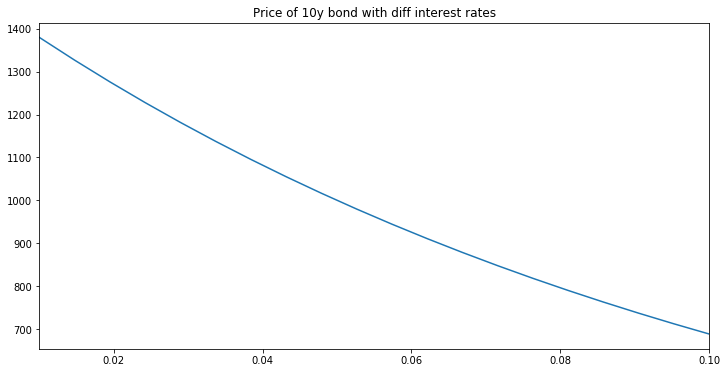

In [12]:
pd.DataFrame(data=prices, index=rates).plot(title="Price of 10y bond with diff interest rates", legend=False, figsize=(12,6))

We are going to construct a combination of bonds that has a resilience to interest rates in the same way that a zero coupon bond has a resilience to Interest rates.

The reason that the zero coupon bond has a resilience to interest rates is that it basically comes down to one payment. 

In [13]:
cf = erk.bond_cash_flows(3, 1000, 0.06, 2)
cf

1      30.0
2      30.0
3      30.0
4      30.0
5      30.0
6    1030.0
dtype: float64

In [14]:
discounts = erk.discount(cf.index, 0.06/2)
discounts

Float64Index([ 0.970873786407767, 0.9425959091337544, 0.9151416593531596,
              0.8884870479156888, 0.8626087843841639, 0.8374842566836542],
             dtype='float64')

In [15]:
dcf = discounts * cf
dcf

1     29.126214
2     28.277877
3     27.454250
4     26.654611
5     25.878264
6    862.608784
dtype: float64

In [17]:
weights = dcf/dcf.sum()
weights

1    0.029126
2    0.028278
3    0.027454
4    0.026655
5    0.025878
6    0.862609
dtype: float64

In [19]:
(cf.index*weights).sum()

5.579707187194534

What this is saying is that the last payment is at 6. In other words, the maturity of the bond is 6 but the weighted average duration that I have to wait weighted by the present value of each of the cash flows is equal to 5.59. I'm not waiting 6 years, I'm waiting 6 years for the last payment but I've already received some before that, so the weighted avg duration that I'm waiting is 5.59 years. This number is called the Macaulay Duration. 

The key insight here is that this is directly related to the rate of change, the first derivative, of the price wrt IR. If the IR moves and you have a large duration, the price will move a lot. The duration is directly linked to the amount by which the price will change when IR change.

What is the duration of a zero coupon bond?
The Macaulay duration is exactly the maturity

For every none zero coupon bond it will have a duration shorter than the maturity

In [21]:
erk.macaulay_duration(erk.bond_cash_flows(3, 1000, 0.06, 2), 0.06/2)

5.579707187194534

Why are we doing this? 

If you can match the macaulay duration of your bonds to the macaulay duration of the liability, you get two portfolios that have the same sensitivity, they change in the same way, with changes in interest rate. 

If you can match the duration of the liabilities and the duration of the bonds that you're holding, as interest rates move your liabilities will move up but your bond portfolio is going to go up by ~the same amount. This is not a perfect match. This only works for parallel shifts of the yield curve, if IR as a whole go up. The yield curve has much more complex behavior that needs to be taken into account for.

## Duration Matching

In [22]:
liabilities = pd.Series(data=[100000, 100000], index=[10, 12])
erk.macaulay_duration(liabilities, 0.04)

10.960799385088393

We've got a 10 year liability and a 12 year liability but based on IR of 0.04 our duration is 10.96. Little less than half way between the two.

If I had a zero coupon bond that had duration of 10.96 that would be great, but let's assume we dont. 

We have a 10 year bond and a 12 year bond. Each of them pay a 5% coupon once a year and has a face value of $1000

What to do?
* Figure out the duration of the bonds that we have.
* We want to construct a portfolio that has a duration of 10.96 but we can't do that unless we know the duration of the bonds we have right now.

In [23]:
md_10 = erk.macaulay_duration(erk.bond_cash_flows(10, 1000, 0.05, 1), 0.04)
md_20 = erk.macaulay_duration(erk.bond_cash_flows(20, 1000, 0.05, 1), 0.04)

In [24]:
md_10, md_20

(8.190898824083233, 13.544718122145921)

Now we know what the duration of these bonds are.

All we have to do is figure out what fraction of each of these two bonds I should hold.

In our case, the fraction in the short duration asset $w_s$, should be such that:
$$w_s \times 8.19 + (1 - w_s) \times 13.54 = 10.96$$

more generally:
$$w_s \times d_s + (1 - w_s) \times d_l = d_t$$

rearrangin gives:

$$w_s = \frac{d_l - d_t}{d_t - d_s}$$

In [25]:
short_bond = erk.bond_cash_flows(10, 1000, 0.05, 1)
long_bond = erk.bond_cash_flows(20, 1000, 0.05, 1)
w_s = erk.match_durations(liabilities, short_bond, long_bond, 0.04)
w_s

0.48263092069478974

This is telling us that we should put 48% of our assets in the short bond and 52% of our assets in the long bond.

First we need to price the bonds. We also need our assets, how much money do we have. we need the cash flows to compute the macaulay duration of this portfolio we are going to buy.

In [27]:
p_short = erk.bond_price(10, 1000, 0.05, 1, 0.04)
p_long = erk.bond_price(20, 1000, 0.05, 1, 0.04)
a_0 = 130000
p_flows = pd.concat([(a_0*w_s*short_bond/p_short), (a_0*(1-w_s)*long_bond/p_long)])
erk.macaulay_duration(p_flows, 0.04)

10.960799385088393

10.96 is the number of periods, the duration, of this particular portfolio. If we look back at the duration of the liabilities, it's the exact same thing.

Let's now compute the funding ratio.

In [28]:
cfr = erk.funding_ratio(p_flows, liabilities, 0.04)
cfr

0.9998760012192478

We're pretty much funded at this point. 

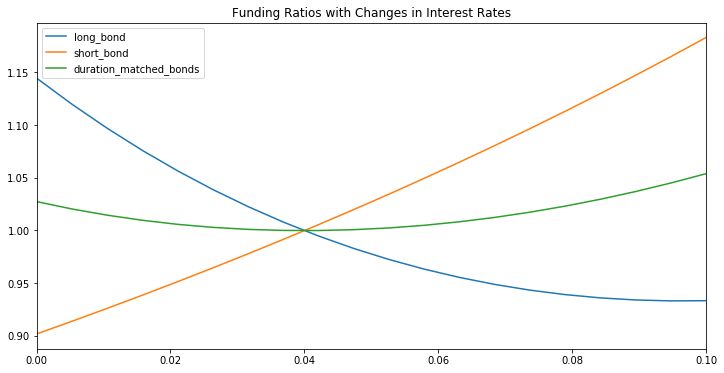

In [31]:
rates = np.linspace(0, 0.1, 20)
lb_assets = a_0*long_bond/p_long # 100% of portfolio in long bond cash flows
sb_assets = a_0*short_bond/p_short

fr_change = pd.DataFrame({
    "long_bond": [erk.funding_ratio(lb_assets, liabilities, r) for r in rates],
    "short_bond": [erk.funding_ratio(sb_assets, liabilities, r) for r in rates],
    "duration_matched_bonds": [erk.funding_ratio(p_flows, liabilities, r) for r in rates]
}, index=rates)

fr_change.plot(title="Funding Ratios with Changes in Interest Rates", figsize=(12,6))

If I'd have put all my money in the long bond my funding ratio would have gone up if IR would have gone down, but if IR have gone up my funding ratio would have plunged.

If I'd have put all my money in the short bond, the opposite happens.

The duration matched portfolio has ver subtle movements. Given todays IR when this things move it's goint to move in a way such that theres almost no change in the funding ratio.